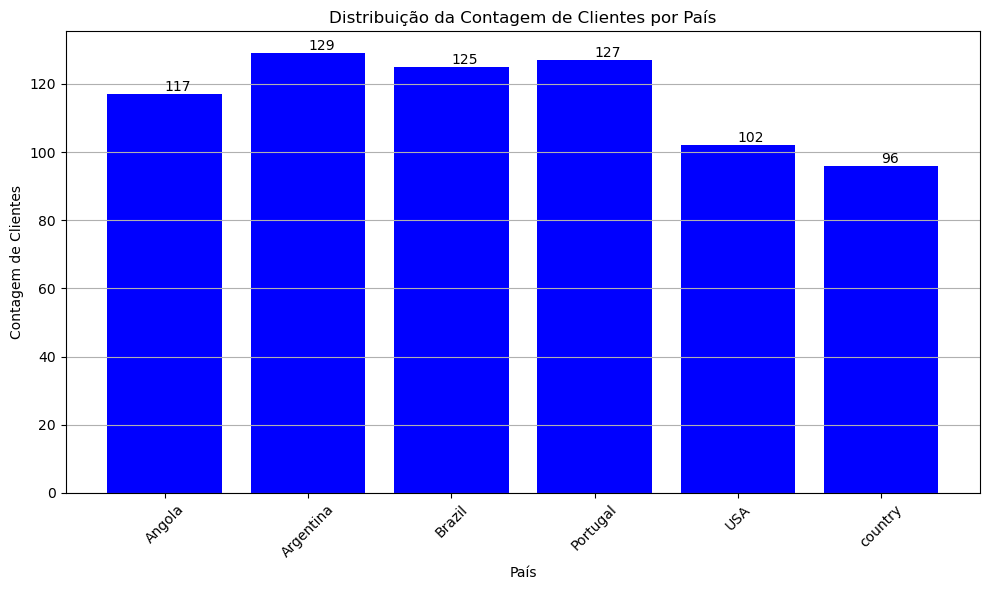

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
import matplotlib.pyplot as plt
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *


# Configuração do Spark
conf = SparkConf()
conf.setAppName("Write Delta Bronze Employee")
conf.set("spark.hadoop.fs.s3a.endpoint", "http://minio:9000")
conf.set("spark.hadoop.fs.s3a.access.key", "chapolin")
conf.set("spark.hadoop.fs.s3a.secret.key", "mudar@123")
conf.set("spark.hadoop.fs.s3a.path.style.access", True)
conf.set("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")
conf.set('spark.hadoop.fs.s3a.aws.credentials.provider', 'org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider')
conf.set("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
conf.set("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") 
conf.set("hive.metastore.uris", "thrift://metastore:9083")

# Inicialização da sessão do Spark
spark = SparkSession.builder.config(conf=conf).enableHiveSupport().getOrCreate()


# Dicionário com caminhos de exportação para diferentes ambientes
path_export_data = {
    'databricks': '/dbfs/mnt/landing_zone/real_time_customer_csv/',
    'fabric': 'Files/',
    'docker': 's3a://landing-zone/customer_real_time/'
}

# Definir o caminho para a pasta no HDFS
hdfs_path = path_export_data['docker'] + "*.csv"

# Definir o esquema manualmente
schema = StructType([
    StructField("firstname", StringType(), True),
    StructField("lastname", StringType(), True),
    StructField("id", IntegerType(), True),
    StructField("country", StringType(), True)
])

# Ler os arquivos para um DataFrame
df = spark.read.format("csv").schema(schema).load(hdfs_path)

# Calcular a contagem de clientes por país
country_counts = df.groupBy("country").count().orderBy("country").toPandas()

# Distribuição da contagem de clientes por país
plt.figure(figsize=(10, 6))
bars = plt.bar(country_counts["country"], country_counts["count"], color='blue')
plt.title('Distribuição da Contagem de Clientes por País')
plt.xlabel('País')
plt.ylabel('Contagem de Clientes')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Adicionar rótulos às barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom')

# Mostrar o gráfico
plt.tight_layout()
plt.show()